In [1]:
# prompt: connect deive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from tqdm import tqdm  # <--- Thêm dòng này

# Đường dẫn dữ liệu
DATA_PATH = '/content/drive/MyDrive/data_sign_language_mediapipe'

# Danh sách các hành động (tự động lấy từ tên thư mục)
actions = np.array(os.listdir(DATA_PATH))

# Danh sách chứa thông tin lỗi
error_log = []

# Duyệt qua từng hành động có thanh tiến trình
for label, action in enumerate(tqdm(actions, desc="Checking actions")):
    action_path = os.path.join(DATA_PATH, action)
    sequences = os.listdir(action_path)
    for sequence in tqdm(sequences, desc=f"Checking {action}", leave=False):
        sequence_path = os.path.join(action_path, sequence)
        has_nan_or_inf = False
        for frame_num in range(40):
            npy_path = os.path.join(sequence_path, f"{frame_num}.npy")
            if os.path.exists(npy_path):
                frame = np.load(npy_path)
                if np.isnan(frame).any() or np.isinf(frame).any():
                    has_nan_or_inf = True
                    break
        if has_nan_or_inf:
            error_log.append(f"{action}/{sequence}")

# Hiển thị kết quả
print("\n[!] Các folder chứa NaN/Inf:")
for item in error_log:
    print(" -", item)

print(f"\nTổng số sequence bị lỗi: {len(error_log)}")


Checking actions: 100%|██████████| 12/12 [3:08:51<00:00, 944.27s/it] 


[!] Các folder chứa NaN/Inf:

Tổng số sequence bị lỗi: 0


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pickle

# ======== Hàm tăng cường dữ liệu =========
def add_gaussian_noise(sequence, mean=0.0, std=0.01):
    noise = np.random.normal(mean, std, sequence.shape)
    return sequence + noise

def rotate_sequence(sequence, axis='z', angle_range=(-10, 10)):
    angle = np.deg2rad(np.random.uniform(*angle_range))
    cos, sin = np.cos(angle), np.sin(angle)

    if axis == 'z':
        R = np.array([[cos, -sin, 0],
                      [sin,  cos, 0],
                      [0,    0,   1]])
    elif axis == 'y':
        R = np.array([[cos,  0, sin],
                      [0,    1, 0],
                      [-sin, 0, cos]])
    elif axis == 'x':
        R = np.array([[1, 0,    0],
                      [0, cos, -sin],
                      [0, sin,  cos]])
    else:
        return sequence  # không xoay

    return np.dot(sequence, R.T)  # nhân từng điểm

# ======== Đọc và xử lý dữ liệu =========
DATA_PATH = '/content/drive/MyDrive/data_sign_language_mediapipe'
actions = np.array(os.listdir(DATA_PATH))

label_map = {i: action for i, action in enumerate(actions)}
label_map_file = '/content/drive/MyDrive/label_map_LSTM_AUGdata_.pkl'
with open(label_map_file, 'wb') as f:
    pickle.dump(label_map, f)
print(f"Label map saved to: {label_map_file}")

sequences, labels = [], []

for label, action in enumerate(actions):
    action_path = os.path.join(DATA_PATH, action)
    for sequence in os.listdir(action_path):
        window = []
        for frame_num in range(40):
            npy_path = os.path.join(action_path, sequence, f"{frame_num}.npy")
            if os.path.exists(npy_path):
                frame = np.load(npy_path)
                window.append(frame)
        if len(window) == 40:
            sequences.append(window)
            labels.append(label)

X = np.array(sequences)
y = to_categorical(labels).astype(int)

# ======== Chia dữ liệu =========
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ======== Tăng cường dữ liệu train =========
augmented_X = []
augmented_y = []

for i in range(len(X_train)):
    seq = X_train[i]
    label = y_train[i]

    # Tăng cường 2 lần mỗi chuỗi
    augmented_X.append(add_gaussian_noise(seq))
    augmented_X.append(rotate_sequence(seq.reshape(-1, 3), axis='z').reshape(seq.shape))  # quay trục Z

    augmented_y.extend([label] * 2)

# Ghép thêm dữ liệu tăng cường vào train
X_train_aug = np.concatenate([X_train, np.array(augmented_X)], axis=0)
y_train_aug = np.concatenate([y_train, np.array(augmented_y)], axis=0)

print("Train:", X_train_aug.shape, y_train_aug.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Label map saved to: /content/drive/MyDrive/label_map_LSTM_AUGdata_.pkl


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Khởi tạo mô hình
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, activation='tanh'), input_shape=(40, 1629)),
    Dropout(0.4),
    Bidirectional(LSTM(64, return_sequences=True, activation='tanh')),
    Dropout(0.3),
    Bidirectional(LSTM(32, return_sequences=False, activation='tanh')),  # Thêm LSTM 3
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(12, activation='softmax')  # 12 lớp phân loại
])

# Biên dịch mô hình
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # One-hot encoding
    metrics=['accuracy']
)

# Thiết lập các callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Hiển thị kiến trúc
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 40, 256)        │     1,800,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 40, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,990,092 (7.59 MB)

 Trainable params: 1,990,092 (7.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:


# Huấn luyện
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32
)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 560ms/step - accuracy: 0.1153 - loss: 2.4821 - val_accuracy: 0.3690 - val_loss: 2.2186
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 439ms/step - accuracy: 0.3183 - loss: 2.1474 - val_accuracy: 0.5119 - val_loss: 1.3892
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 505ms/step - accuracy: 0.5269 - loss: 1.3314 - val_accuracy: 0.5952 - val_loss: 0.7461
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 398ms/step - accuracy: 0.6155 - loss: 0.8630 - val_accuracy: 0.7738 - val_loss: 0.4996
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 413ms/step - accuracy: 0.7134 - loss: 0.6620 - val_accuracy: 0.7381 - val_loss: 0.5267
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 554ms/step - accuracy: 0.7046 - loss: 0.6270 - val_accuracy: 0.8095 - val_loss: 0.3656
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 450ms/step - accuracy: 0.8258 - loss: 0.3895 - val_accuracy: 0.9048 - val_loss: 0.3385
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 389ms/step - accuracy: 0.7883 - loss: 0.4071 - v

In [ ]:
# Lưu mô hình vào MyDrive
model.save('/content/drive/MyDrive/sign_language_LSTM_AUGdata_model.keras')
print("✅ Mô hình đã được lưu tại: /content/drive/MyDrive/sign_language_model.keras")

✅ Mô hình đã được lưu tại: /content/drive/MyDrive/sign_language_model.keras


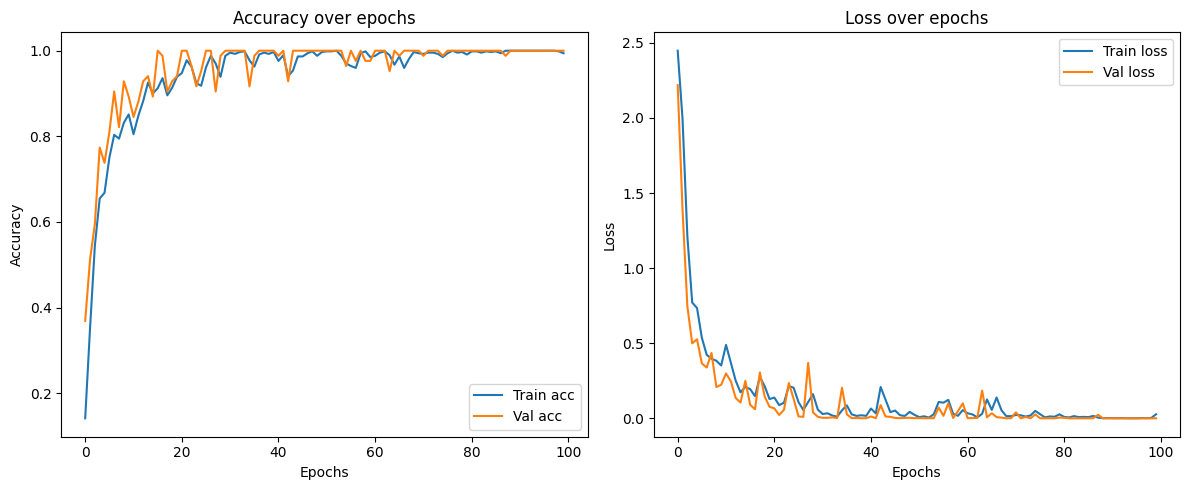

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 603ms/step


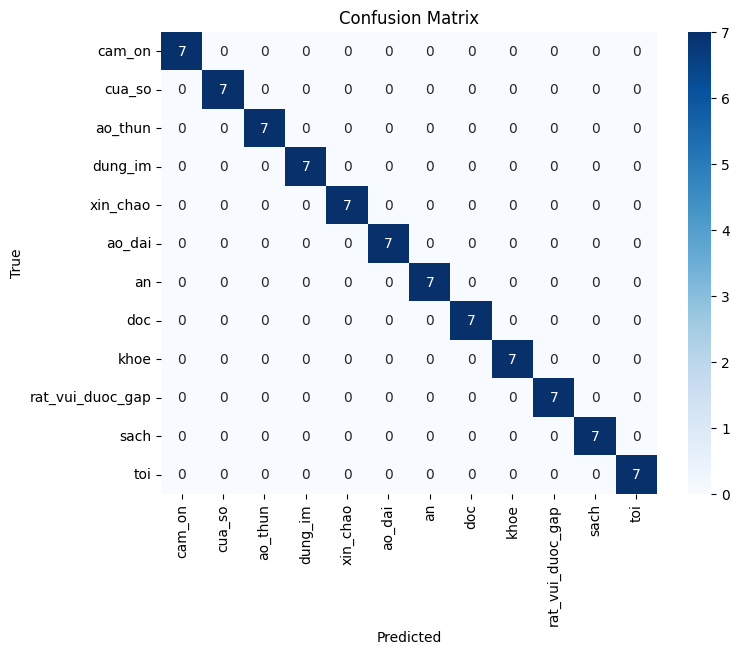

Classification Report:
                  precision    recall  f1-score   support

          cam_on       1.00      1.00      1.00         7
          cua_so       1.00      1.00      1.00         7
         ao_thun       1.00      1.00      1.00         7
         dung_im       1.00      1.00      1.00         7
        xin_chao       1.00      1.00      1.00         7
          ao_dai       1.00      1.00      1.00         7
              an       1.00      1.00      1.00         7
             doc       1.00      1.00      1.00         7
            khoe       1.00      1.00      1.00         7
rat_vui_duoc_gap       1.00      1.00      1.00         7
            sach       1.00      1.00      1.00         7
             toi       1.00      1.00      1.00         7

        accuracy                           1.00        84
       macro avg       1.00      1.00      1.00        84
    weighted avg       1.00      1.00      1.00        84



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# 1. Vẽ biểu đồ độ chính xác và mất mát
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train acc')
    plt.plot(history.history['val_accuracy'], label='Val acc')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 2. Confusion Matrix & Classification Report
def evaluate_model(model, X_test, y_test, actions):
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=actions, yticklabels=actions)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred_labels, target_names=actions))

# Gọi các hàm:
plot_training_history(history)
evaluate_model(model, X_test, y_test, actions)
